# Comparison

We can run simulations for all methods in order to compare their performances. A complication is that they all have a parameter. To get a meaningful comparison we have to consider their performance as a function of their parameter. We summarize a complete learning curve by its average value over the 1000 steps and shows this measure for the various bandit algorithms, each as a function of its own parameter shown on a single scale on the x-axis. This kind of graph is called a **parameter study**. 

In [5]:
import numpy as np

class BanditEnv:
    def __init__(self):
        self.size = 10                                        # 10 arms
        self.means = np.random.randn(self.size)
        
    def step(self, action):
        return np.random.normal(loc=self.means[action])
    
env = BanditEnv()

In [6]:
envs = []
for i in range(2000):
    envs.append(BanditEnv());

In [7]:
def epsilon_greedy(env, epsilon=0.01, n_episodes=1000):
    
    # The baseline boilerplate is the same as before
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)
    
    for e in range(n_episodes):
        
        # draw a random number and compare to a hyperparameter epsilon
        if np.random.uniform() > epsilon:
            # if it is greater than epsilon, exploit:
            action = np.argmax(Q)
        else:
            # otherwise, explore:
            action = np.random.randint(len(Q))

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return returns, Qe, actions

In [8]:
def optimistic_initialization(env, optimistic_estimate=5.0,
                              initial_count=10, n_episodes=1000):
    
    # start initializing the Q-values to an optimistic value
    Q = np.full((env.size), optimistic_estimate, dtype=float)
    
    # initialize the counts that will serve as an uncertainty measure
    # the higher the more certain.
    N = np.full((env.size), initial_count, dtype=int)
    
    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)

    for e in range(n_episodes):
        
        action = np.argmax(Q)

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]

        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
        
    return returns, Qe, actions

In [9]:
def softmax(env, init_temp=1000, min_temp=0.1,
            decay_ratio=0.04,n_episodes=1000):
    
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)
    
    for e in range(n_episodes):
        
        # calculate the linearly decaying temperature 
        decay_episodes = n_episodes * decay_ratio
        temp = 1 - e / decay_episodes
        temp *= init_temp - min_temp
        temp += min_temp
        temp = np.clip(temp, min_temp, init_temp)

        # calculate the probabilities by applying the softmax function 
        # to the estimates
        scaled_Q = Q / temp
        norm_Q = scaled_Q - np.max(scaled_Q)
        exp_Q = np.exp(norm_Q)
        probs = exp_Q / np.sum(exp_Q)
    
        # select the action based on probabilities
        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return returns, Qe, actions

In [10]:
def upper_confidence_bound(env, c=2, n_episodes=1000):
    
    Q = np.zeros((env.size), dtype=float)
    N = np.zeros((env.size), dtype=int)
    
    Qe = np.empty((n_episodes, env.size), dtype=float)
    returns = np.empty(n_episodes, dtype=float)
    actions = np.empty(n_episodes, dtype=int)

    for e in range(n_episodes):
        # first select all actions once to avoid division by zero
        if e < len(Q):
            action = e    
        else: 
            # proceed to calculating the confidence bounds
            U = np.sqrt(c * np.log(e)/N)
            # pick the action with the highest value with an 
            # uncertainty bonus: the more uncertain the value of the action, 
            # the higher the bonus
            action = np.argmax(Q + U)

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
        
    return returns, Qe, actions

In [13]:
from tqdm import tqdm

def run_experiment(envs, algorithm, param):    
    returns = [];

    desc = 'Running ' + algorithm + ' with parameter ' + str(param);

    for i in tqdm(range(2000), desc=desc):

        if algorithm == 'epsilon-greedy':
            r, _, _ = epsilon_greedy(env, epsilon=param, n_episodes=1000);
        elif algorithm == 'optimistic-initialization':
            r,_ ,_ = optimistic_initialization(env, optimistic_estimate=param, initial_count=10, n_episodes=1000);
        elif algorithm == 'softmax':
            r,_ ,_ = softmax(env, init_temp=param, min_temp=0.1, decay_ratio=0.04,n_episodes=1000);
        elif algorithm == 'ucb':
            r,_ ,_ = upper_confidence_bound(env, c=param, n_episodes=1000);
        else:
            raise ValueError('Unknown algorithm:', algorithm)
        
        returns.append(r);
    
    returns = np.array(returns);
    return returns.mean()

In [14]:
egreedy_x, egreedy_y = [], []
for param in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]:
    result = run_experiment(envs=envs, algorithm='epsilon-greedy', param=param);
    egreedy_x.append(param)
    egreedy_y.append(result)

Running epsilon-greedy with parameter 0.0078125:   0%|          | 0/2000 [00:00<?, ?it/s]

Running epsilon-greedy with parameter 0.25: 100%|██████████| 2000/2000 [00:07<00:00, 268.33it/s]


In [15]:
opt_x, opt_y = [], []
for param in [1/4, 1/2, 1, 2, 4, 6]:
    result = run_experiment(envs=envs, algorithm='optimistic-initialization', param=param)
    opt_x.append(param)
    opt_y.append(result)

Running optimistic-initialization with parameter 0.25: 100%|██████████| 2000/2000 [00:04<00:00, 411.25it/s]
Running optimistic-initialization with parameter 0.5: 100%|██████████| 2000/2000 [00:04<00:00, 414.58it/s]
Running optimistic-initialization with parameter 1: 100%|██████████| 2000/2000 [00:04<00:00, 421.62it/s]
Running optimistic-initialization with parameter 2: 100%|██████████| 2000/2000 [00:04<00:00, 430.23it/s]
Running optimistic-initialization with parameter 4: 100%|██████████| 2000/2000 [00:04<00:00, 417.17it/s]
Running optimistic-initialization with parameter 6: 100%|██████████| 2000/2000 [00:04<00:00, 429.09it/s]


In [17]:
ucb_x, ucb_y = [], []
for param in [1/16, 1/8, 1/4, 1/2, 1, 2, 4]:
    result = run_experiment(envs=envs, algorithm='ucb', param=param)
    ucb_x.append(param)
    ucb_y.append(result)

Running ucb with parameter 4: 100%|██████████| 2000/2000 [00:09<00:00, 220.05it/s]


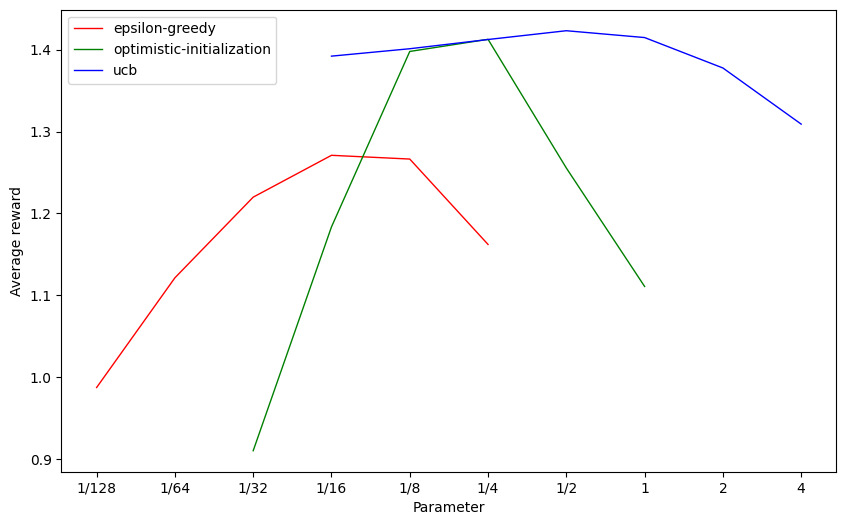

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

plt.xticks(range(-7, 3), ('1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1', '2', '4'))
plt.plot(range(-7, -1), egreedy_y, linewidth=1, color='red', label='epsilon-greedy')
plt.plot(range(-5, 1), opt_y, linewidth=1, color='green', label='optimistic-initialization')
plt.plot(range(-4, 3), ucb_y, linewidth=1, color='blue', label='ucb')

plt.xlabel('Parameter')
plt.ylabel('Average reward')
plt.legend()

plt.show()

Overall, on this problem, **UCB seems to perform best**. Notice the characteristic **inverted-U shapes** of each algorithm’s performance: all the algorithms perform best at an **intermediate value of their parameter**, neither too large nor too small. In assessing a method, we should attend not just to how well it does at its best parameter setting, but also to **how sensitive it is to its parameter value**. All of these algorithms are fairly insensitive, performing well over a range of parameter values varying by about an order of magnitude. 